In [ ]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

In [1]:
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf
import qutip as qt
from matplotlib import pyplot as plt

We also declare a 3-qubit simulator device running in Cirq.


In [2]:
dev = qml.device('cirq.simulator', wires=3)

Generator and Discriminator
===========================




In [49]:

def generator(w):
    #qml.Hadamard(wires=0)
    qml.RY(w[0],wires = 0)
    qml.CNOT(wires = [0,1])
    qml.RX(w[1],wires = 0)
    qml.RZ(w[2],wires = 0)
    
    

def U1(w,wire):
    qml.RZ(w[0],wires = wire)
    qml.RX(w[1],wires = wire)
    qml.RZ(w[2],wires = wire)    
    
def discriminator(w):
    #qml.Hadamard(wires=0)
    #qml.CNOT(wires = [1,0])
    #qml.RY(w[0],wires = 1)
    #qml.CNOT(wires = [0,1])
    #qml.RY(w[1],wires = 1)
    #qml.CNOT(wires = [1,0])
    #qml.RZ(w[2],wires = 0)
    #qml.RX(w[3],wires = 0)
    
    #qml.Hadamard(wires=0)
    #qml.RX(w[0], wires=0)
    #qml.RX(w[1], wires=2)
    #qml.RY(w[2], wires=0)
    #qml.RY(w[3], wires=2)
    #qml.RZ(w[4], wires=0)
    #qml.RZ(w[5], wires=2)
    #qml.CNOT(wires=[0, 2])
    #qml.RX(w[6], wires=2)
    #qml.RY(w[7], wires=2)
    #qml.RZ(w[8], wires=2)
    U1(w[0:3], 0)
    U1(w[3:6], 2)
    qml.CNOT(wires = [2,0])
    qml.RZ(w[6],wires = 0)
    qml.RY(w[7],wires = 2)
    qml.CNOT(wires = [0,2])
    qml.RY(w[8],wires = 2)
    qml.CNOT(wires = [2,0])
    U1(w[9:12], 0)
    U1(w[12:15],2)
    
def real(w):
    generator(w)

# Nodes

In [4]:
@qml.qnode(dev, diff_method="parameter-shift")
def real_disc_circuit(real_params, disc_weights):
    real(real_params)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(1))

@qml.qnode(dev, diff_method="parameter-shift")
def gen_disc_circuit(gen_weights, disc_weights):
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(1))



QGAN cost functions
===================




In [5]:
def prob_real_true(disc_weights):
    true_disc_output = real_disc_circuit(real_params, disc_weights)
    # convert to probability
    prob_real_true = (true_disc_output + 1) / 2
    return prob_real_true


def prob_fake_true(gen_weights, disc_weights):
    fake_disc_output = gen_disc_circuit(gen_weights, disc_weights)
    # convert to probability
    prob_fake_true = (fake_disc_output + 1) / 2
    return prob_fake_true


def disc_cost(disc_weights):
    cost = prob_fake_true(gen_weights, disc_weights) - prob_real_true(disc_weights)
    return cost


def gen_cost(gen_weights):
    cost = -prob_fake_true(gen_weights, disc_weights)
    return cost

Initializing the weights
=================


Real state generation

In [52]:
np.random.seed(1)
real_params = np.random.uniform(low=-np.pi, high=np.pi, size=3)

Generator and Discriminator parameter initialization

In [7]:
np.random.seed(17)
init_gen_weights = np.random.uniform(low=-np.pi, high=np.pi, size=3)
np.random.seed(17)
init_disc_weights = np.random.uniform(low=-np.pi, high=np.pi, size=15)

gen_weights=np.array(list(init_gen_weights), requires_grad=False)

disc_weights=np.array(list(init_disc_weights), requires_grad=True)

We begin by creating the optimizer:


In [8]:
opt1=qml.GradientDescentOptimizer(stepsize=0.05)
opt2=qml.GradientDescentOptimizer(stepsize=0.05)

We train in turns. We expect around 250 turns to converge. Each turn consists of 5 discriminator steps and 1 generator step.

# Define some other metrics

In [26]:
dev_state = qml.device('default.qubit', wires=2)

In [36]:
@qml.qnode(dev_state, interface="tf")
def real_circuit(w):
    generator(w)
    return qml.density_matrix([0])


@qml.qnode(dev_state, interface="tf")
def gen_circuit(gen_weights):
    generator(gen_weights)
    return qml.density_matrix([0])

In [55]:
def F_Tr_state(real_params,gen_weights):
    real_state = qt.Qobj(real_circuit(real_params).numpy())
    gen_state = qt.Qobj(gen_circuit(gen_weights).numpy())
    
    F = qt.fidelity(real_state,gen_state)
    d = qt.tracedist(real_state,gen_state)
    
    return (F,d,real_state,gen_state)

Visualize the real state, let's see if it's mixed

In [56]:
real_state = qt.Qobj(real_circuit(real_params).numpy())
(real_state*real_state).tr()

0.8759655184579888

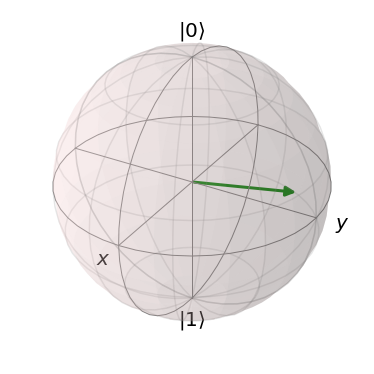

In [57]:
b = qt.Bloch()

b.add_states(real_state)
b.render()

# Training routine

In [58]:
#----- Metrics ----------------------------

Disc_cost = [] # P(R|R)-P(R|G)
Gen_cost = [] # P(R|G)
Trace_d = [] #Trace distance
F = [] #Fidelity
States = []


#-------------------------------------------

costD = lambda: disc_cost(disc_weights)
costG = lambda: gen_cost(gen_weights)

#print("gen_weights", gen_weights)
#print("disc_weights", disc_weights)

for turn in range(100):
    print("Begin "+ str(turn) + " discriminator optimization")
    disc_weights=np.array(list(disc_weights), requires_grad=True)
    gen_weights=np.array(list(gen_weights), requires_grad=False)
    for step in range(5): #The actual ratio should be 20 to 1, according to what we discussed
        #opt.minimize(costD, disc_weights)
        print("Before "+str(step) + " disc gradient computation of "+str(turn)+ " round of optimization")
        #grad_fn_disc=real_disc_circuit_gradient(disc_weights)-gen_disc_circuit_gradient_disc(disc_weights)
        grad_gen_circuit_disc=qml.grad(gen_disc_circuit, argnum=1)
        grad_real_disc_circuit=qml.grad(real_disc_circuit, argnum=1) 
        grad_fn_disc=grad_gen_circuit_disc(gen_weights, disc_weights)-grad_real_disc_circuit(real_params, disc_weights)
        #print("grad_fn_disc", grad_fn_disc)
        print("After"+str(step) + " disc gradient computation of "+str(turn)+ " round of optimization")
        disc_weights=np.array(opt1.apply_grad(grad_fn_disc, disc_weights), requires_grad=True)
        #disc_weights=np.array(opt1.step(disc_cost, disc_weights), requires_grad=True)
        #print("disc_weights", disc_weights)
        print("After"+str(step) + " disc opt update of "+str(turn)+ " round of optimization")

        if step == 4:
            costD_val = costD().numpy()
            print("Step {}: cost = {}".format(step, costD_val))
            Disc_cost += [-costD_val] # P(R|R)-P(R|G)
    print("End of " + str(turn)+" discriminator optimization")    
    print("end of "+ str(turn)+ " optimization ")
            #opt.minimize(costG, gen_weights)
    disc_weights=np.array(list(disc_weights), requires_grad=False)
    gen_weights=np.array(list(gen_weights), requires_grad=True)
    print("Begin of "+str(turn)+" generator optimization")
    #print("gen_weights", gen_weights)
    #print("disc_weights", disc_weights)
    #disc_weights=np.array(list(disc_weights), requires_grad=False)
    #gen_weights=np.array(list(gen_weights), requires_grad=True)

    print("Before gen gradient computation")
    #grad_fn_gen=-gen_disc_circuit_gradient_gen(gen_weights)
    grad_fn_gen=-qml.grad(gen_disc_circuit, argnum=0)(gen_weights, disc_weights)
    #print("grad_fn_gen", grad_fn_gen)
    print("After gen gradient computation")
    gen_weights=np.array(opt2.apply_grad(grad_fn_gen, gen_weights), requires_grad=True)
    #gen_weights=np.array(opt2.step(gen_cost, gen_weights), requires_grad=True)
    #print("gen_weights", gen_weights)
    #print("disc_weights", disc_weights)
    print("After gen opt update ")
    costG_val = costG().numpy()
    #print("Step {}: cost = {}".format(step, costG_val))
    Gen_cost += [-costG_val] # P(R|G)
    
 

    F_Tr_st = F_Tr_state(real_params,gen_weights)
    
    
    F += [F_Tr_st[0]] #Fidelity
    Trace_d += [F_Tr_st[1]] #Trace distance
    States += [F_Tr_st[3]]
    
    print("P(R|R)-P(R|G): ", -costD_val)
    print("P(R|G): ", -costG_val)
    print("Fidelity: ",F_Tr_st[0])
    print("Trace distance: ",F_Tr_st[1])
    print("------------------------------")

Begin 0 discriminator optimization
Before 0 disc gradient computation of 0 round of optimization
After0 disc gradient computation of 0 round of optimization
After0 disc opt update of 0 round of optimization
Before 1 disc gradient computation of 0 round of optimization
After1 disc gradient computation of 0 round of optimization
After1 disc opt update of 0 round of optimization
Before 2 disc gradient computation of 0 round of optimization
After2 disc gradient computation of 0 round of optimization
After2 disc opt update of 0 round of optimization
Before 3 disc gradient computation of 0 round of optimization
After3 disc gradient computation of 0 round of optimization
After3 disc opt update of 0 round of optimization
Before 4 disc gradient computation of 0 round of optimization
After4 disc gradient computation of 0 round of optimization
After4 disc opt update of 0 round of optimization
Step 4: cost = -0.2950853109359741
End of 0 discriminator optimization
end of 0 optimization 
Begin of 0 

In [59]:
F = np.array(F)
Gen_cost = np.array(Gen_cost)
Disc_cost = np.array(Disc_cost)
Trace_d = np.array(Trace_d)

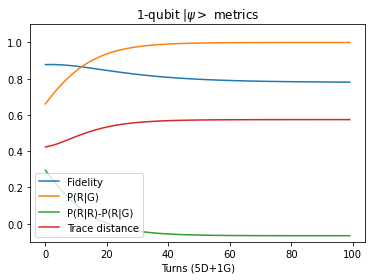

In [61]:
plt.plot(F, label='Fidelity')
plt.plot(Gen_cost, label='P(R|G)')
plt.plot(Disc_cost, label='P(R|R)-P(R|G)')
plt.plot(Trace_d, label='Trace distance')
plt.ylim([-0.1,1.1])
plt.xlabel('Turns (5D+1G)') 
plt.title("1-qubit $|\psi>$ metrics")
plt.legend()
plt.savefig('1qubitlearning_parameter_shift.png', format='png')

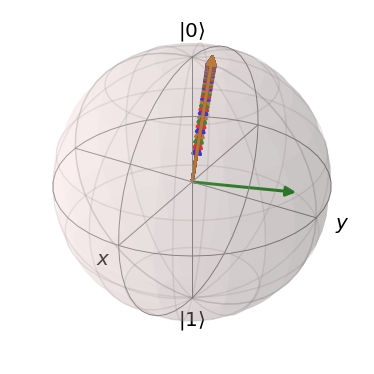

In [64]:
b = qt.Bloch()

final_real = qt.Qobj(real_circuit(real_params).numpy())
final_gen =  qt.Qobj(gen_circuit(gen_weights).numpy())
b.add_states(final_real)
b.add_states(final_gen)
b.add_states(States)
b.render()
plt.savefig('blochsphere.png', format='png')
print()